# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
!pip install -U scikit-learn
!pip install matplotlib==3.7.1

     |████████████████████████████████| 17.3 MB 1.9 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.4 which is incompatible.


Устанавливаю необходимые версии библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import matplotlib
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
import warnings

In [3]:
print('Версия sciket-learn:',sklearn.__version__)
print('Версия matplotlib:',matplotlib.__version__)

Версия sciket-learn: 1.6.1
Версия matplotlib: 3.7.1


Импортирую библиотеки

In [4]:
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
nlp = spacy.load("en_core_web_sm")

Константы

In [5]:
#Визуализация
def cat_plot(data,column):
    plt.figure(figsize=(10,5))
    sns.countplot(data=data,x=column)
    plt.xlabel(f'Значения {column}')
    plt.ylabel('Количество')
    plt.title(f'Распределение данных столбца {column}')
    plt.grid()
    plt.show()


#Лемматизация и отчистка текста от спецсимволов и цифр
def preprocess(texts):
    lemm_texts = []
    negative = ['no','not',"n't"]
    pronouns = ['we','they','i','he','she','it','you']
    for text in tqdm(texts, desc="SpaCy preprocessing"):
        doc = nlp(text.lower())
        lemm = [
            token.lemma_ 
            for token in doc 
            if token.is_alpha and (
                not token.is_stop 
                or token.lemma_ in negative 
                or token.lemma_ in pronouns
            )
        ]
        lemm_texts.append(" ".join(lemm))
    return lemm_texts

In [6]:
sentence1 = "The striped bats are hanging on their feet for best"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)

                                                text
0  The striped bats are hanging on their feet for...
1      you should be ashamed of yourself went worked


Создаю предложения для проверки функции лемматизации

In [7]:
df_my['lemm'] = preprocess(df_my['text'])

SpaCy preprocessing: 100%|██████████| 2/2 [00:00<00:00, 87.30it/s]


Лемматизирую текст

In [8]:
display(df_my)

,text,lemm
0,The striped bats are hanging on their feet for...,stripe bat hang foot good
1,you should be ashamed of yourself went worked,you ashamed go work


Каждое слово в тексте было успешно приведено к лемме, стоп слова удалены точечно, при этом смысл предложений остался

Функции

## Подготовка

**Загрузка данных**

In [9]:
data = pd.read_csv('/datasets/toxic_comments.csv')

**Первичный осмотр**

In [10]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [12]:
data.duplicated().sum()

0

In [13]:
data[['text','toxic']].duplicated().sum()

0

Данные загружены корректно, пропуски и дубликаты не выявлены. Содержание датасета соответствует описанию. 

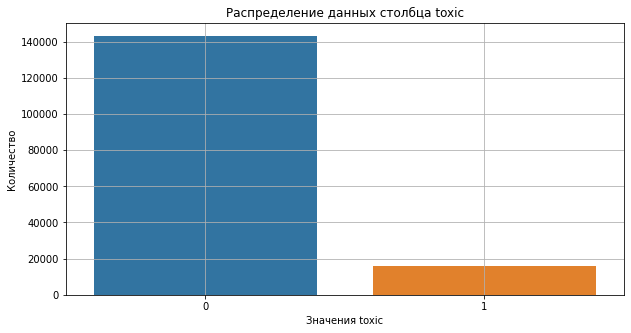

In [14]:
cat_plot(data, 'toxic')

В данных наблюдается существенный дисбаланс классов, необходимо это учесть при разделении данных

**Предобработка данных**

In [15]:
data_copy = data.copy()

Создаю копию датасета

In [16]:
data_copy = data_copy.drop('Unnamed: 0',axis=1)

Удаляю неинформативный признак

In [17]:
data_copy.columns

Index(['text', 'toxic'], dtype='object')

In [18]:
data_copy['lemm_text'] = preprocess(data_copy['text'])

SpaCy preprocessing: 100%|██████████| 159292/159292 [44:30<00:00, 59.65it/s]  


In [19]:
data_copy.to_csv('data_copy.csv', index=False)

In [20]:
data_copy['lemm_text']

0         explanation edit username hardcore metallica f...
1         he match background colour seemingly stuck tha...
2         hey man not try edit war it guy constantly rem...
3         real suggestion improvement wonder section sta...
4                     you sir hero chance you remember page
                                ...                        
159287    second time asking view completely contradict ...
159288             you ashamed horrible thing you talk page
159289    spitzer umm s no actual article prostitution r...
159290    it look like it actually you speedy version de...
159291    think you understand come idea bad right away ...
Name: lemm_text, Length: 159292, dtype: object

Лемматизирую текст

In [21]:
X_train,X_test,y_train,y_test = train_test_split(data_copy['lemm_text'],
                                                 data_copy['toxic'],
                                                 test_size = 0.2,
                                                 random_state=RANDOM_STATE,
                                                 stratify=data_copy['toxic']
)


Делю данные на тестовую и тренировочную выборки


In [22]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Создаю признаковое описание для модели за счет tfidf векторизации.

## Обучение

In [23]:
pipeline = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ('model',LogisticRegression(random_state=RANDOM_STATE))
])

In [24]:
param_grid = [
    {
        'tfidf__ngram_range':[(1,1),(1,2)],
        'tfidf__max_features':[5000,10000],
        'model':[LogisticRegression(max_iter=5000)]
    },
    {
        'tfidf__ngram_range':[(1,1),(1,2)],
        'tfidf__max_features':[5000,10000],
        'model':[LinearSVC(random_state=RANDOM_STATE)],
        'model__C':[1,2,3],
        'model__max_iter':[3000,5000]
    }
]

In [25]:
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=2,
    scoring='f1',
    n_jobs=-1,
    verbose=3
)
grid.fit(X_train,y_train)

Fitting 2 folds for each of 28 candidates, totalling 56 fits
[CV 1/2] END model=LogisticRegression(max_iter=5000), tfidf__max_features=5000, tfidf__ngram_range=(1, 1);, score=0.725 total time=   4.1s
[CV 2/2] END model=LogisticRegression(max_iter=5000), tfidf__max_features=5000, tfidf__ngram_range=(1, 1);, score=0.726 total time=   3.9s
[CV 1/2] END model=LogisticRegression(max_iter=5000), tfidf__max_features=5000, tfidf__ngram_range=(1, 2);, score=0.717 total time=  12.5s
[CV 2/2] END model=LogisticRegression(max_iter=5000), tfidf__max_features=5000, tfidf__ngram_range=(1, 2);, score=0.719 total time=  12.3s
[CV 1/2] END model=LogisticRegression(max_iter=5000), tfidf__max_features=10000, tfidf__ngram_range=(1, 1);, score=0.720 total time=   7.8s
[CV 2/2] END model=LogisticRegression(max_iter=5000), tfidf__max_features=10000, tfidf__ngram_range=(1, 1);, score=0.719 total time=   9.5s
[CV 1/2] END model=LogisticRegression(max_iter=5000), tfidf__max_features=10000, tfidf__ngram_range=(1,

In [26]:
print('Лучшая модель и её параметры:\n', grid.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', (grid.best_score_))

Лучшая модель и её параметры:
 Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=10000)),
                ('model', LinearSVC(C=1, max_iter=3000, random_state=42))])
Метрика лучшей модели на кросс-валидации: 0.7705768687312645


Лучше всего себя показала модель LinearSVC с параметрами (C=1, max_iter=3000, random_state=42) и векторизация с гипперпараметром max_features = 10000. Берем её как основную модель

In [27]:
best_model = grid.best_estimator_
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
print('Значение метрики f1_score на тесте:',f1_score(y_pred,y_test))

Значение метрики f1_score на тесте: 0.7826682651138893


Значение метрики на тесте оказалось выше, чем результат метрики на кросс-валидации (0.783 > 0.77), что говорит о том, что модель успешно нашла зависимости и способна обобщаться на новых данных.

In [28]:
vectorizer = grid.best_estimator_.named_steps['tfidf']
model = grid.best_estimator_.named_steps['model']

words = vectorizer.get_feature_names_out()
coefs = model.coef_[0]

Коэффициенты и нумерация токенов

In [29]:
importance_df = pd.DataFrame({
    'word': words,
    'coef': coefs
}).sort_values('coef', ascending=False).head(20)

Создаю датафрейм с топ 20 словами по важности для модели

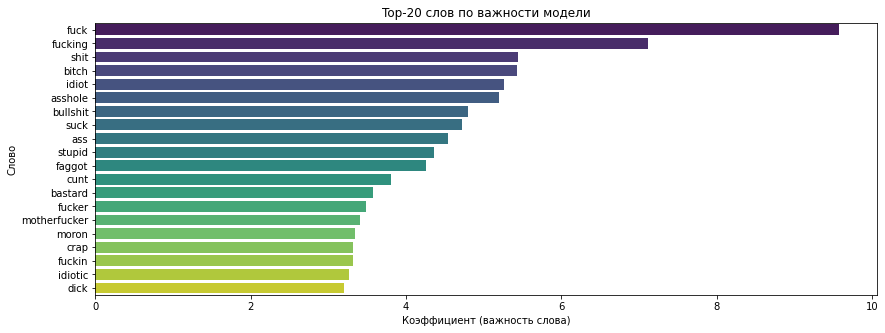

In [30]:
plt.figure(figsize=(14,5))
sns.barplot(x='coef', y='word', data=importance_df, palette='viridis')
plt.title('Top-20 слов по важности модели')
plt.xlabel('Коэффициент (важность слова)')
plt.ylabel('Слово')
plt.show()

По результатам обучения, модель нашла наибольшую зависимость негативных комментариев со следующими словами:
* fuck (коэффициент = 9.58)
* fucking (коэффициент = 7.12)
* shit (коэффициент = 5.45)
* bitch (коэффициент = 5.43)
* idiot (коэффициент = 5.26)
* asshole (коэффициент = 5.19)
* bullshit (коэффициент = 4.80)
* suck (коэффициент = 4.73)
* ass (коэффициент = 4.55)
* stupid (коэффициент = 4.36)
* faggot (коэффициент = 4.26)

## Вывод:

**Цель проекта:** создать модель для автоматического выявления токсичных комментариев в пользовательских правках интернет-магазина «Викишоп». Минимальное требование по метрике F1 — не ниже 0.75.

**Предобработка данных:**

* Данные загружены корректно, пропусков и дубликатов не выявлено.

* Удалён неинформативный признак.

* Обнаружен дисбаланс классов, учтён при разделении на train/test.

* Тексты очищены и лемматизированы, приведены к нижнему регистру.

* Создано векторное представление признаков с помощью TF-IDF.

**Обучение моделей:**

Для классификации негативных комментариев использовались следующие модели с подбором гипперпараметров:
* LogisticRegression
* LinearSVC

Метрика для оценки качества модели - f1_score.

**Итог:** лучшей моделью выбрана LinearSVC(C=1, max_iter=3000, random_state=42), так как она удовлетворяет целевому уровню качества и показала F1 > 0.75. 

Топ 3 самых важных слова для модели оказались:

**1)** "fuck"

**2)** "fucking"

**3)** "shit"

**Рекомендации:**

Для дальнейшего повышения качества можно протестировать ансамблевые модели (CatBoost, LightGBM, XGBoost и другие) или предобученные эмбеддинги (BERT).